Try to enable TPU 


## Load the data we will use:




In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### Allows for checkpoints to be stored in google drive (Not sure we need this)

In [2]:
import os
from google.colab import drive
drive.mount('/content/drive')
checkpoints = '/content/drive/MyDrive/colab_files/birds/'
if not os.path.exists(checkpoints):
    os.makedirs(checkpoints)

Mounted at /content/drive


In [ ]:
from matplotlib.lines import ls_mapper_r
import os

if not os.path.exists('birds23wi'):
    !mkdir birds23wi
    os.chdir('birds23wi')

    !wget https://pjreddie.com/media/files/birds/train.tar
    !wget https://pjreddie.com/media/files/birds/test.tar
    !wget https://pjreddie.com/media/files/birds/names.txt
    !tar xf train.tar
    !tar xf test.tar
    !mkdir testing
    !mv test testing
    os.chdir('..')




In [4]:
def get_bird_data(augmentation=0):
    if (augmentation == 1):
      transform_train = transforms.Compose([
          transforms.Resize(128),
          transforms.RandomCrop(128, padding=8, padding_mode='edge'), # Take 128x128 crops from padded images
          transforms.RandomHorizontalFlip(),    # 50% of time flip image along y-axis
          transforms.ToTensor(),
      ])
    elif augmentation == 2: ## color jitter
      transform_train = transforms.Compose([
        transforms.Resize(256),
        transforms.RandomResizedCrop(size=224, scale=(0.5, 1.0)),
        transforms.RandomHorizontalFlip(),    # 50% of time flip image along y-axis
        transforms.ToTensor(),
        # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
      ])
    else:
      transform_train = transforms.ToTensor()

    transform_test = transforms.Compose([
        transforms.Resize(128),
        transforms.ToTensor(),
    ])

    trainset = torchvision.datasets.ImageFolder(root='birds23wi/train', transform=transform_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

    testset = torchvision.datasets.ImageFolder(root='birds23wi/testing', transform=transform_test)
    testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False, num_workers=2)
    classes = open("birds23wi/names.txt").read().strip().split("\n")
    class_to_idx = trainset.class_to_idx
    idx_to_class = {int(v): int(k) for k, v in class_to_idx.items()}
    idx_to_name = {k: classes[v] for k,v in idx_to_class.items()}
    return {'train': trainloader, 'test': testloader, 'to_class': idx_to_class, 'to_name':idx_to_name}

data = get_bird_data(2)

In [ ]:
dataiter = iter(data['train'])
images, labels = next(dataiter)
images = images[:8]
print(images.size())

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print("Labels:" + ', '.join('%9s' % data['to_name'][labels[j].item()] for j in range(8)))


In [ ]:
def train(net, dataloader, epochs=1, start_epoch=0, lr=0.01, momentum=0.9, decay=0.0005, 
          verbose=1, print_every=10, state=None, schedule={}, checkpoint_path=None):
    net.to(device)
    net.train()
    losses = []
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=decay)

    # Load previous training state
    if state:
        net.load_state_dict(state['net'])
        optimizer.load_state_dict(state['optimizer'])
        start_epoch = state['epoch']
        losses = state['losses']

    # Fast forward lr schedule through already trained epochs
    for epoch in range(start_epoch):
        if epoch in schedule:
            print ("Learning rate: %f"% schedule[epoch])
            for g in optimizer.param_groups:
                g['lr'] = schedule[epoch]

    for epoch in range(start_epoch, epochs):
        sum_loss = 0.0

        # Update learning rate when scheduled
        if epoch in schedule:
            print ("Learning rate: %f"% schedule[epoch])
            for g in optimizer.param_groups:
                g['lr'] = schedule[epoch]

        for i, batch in enumerate(dataloader, 0):
            inputs, labels = batch[0].to(device), batch[1].to(device)

            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()  # autograd magic, computes all the partial derivatives
            optimizer.step() # takes a step in gradient direction

            losses.append(loss.item())
            sum_loss += loss.item()

            if i % print_every == print_every-1:    # print every 10 mini-batches
                if verbose:
                  print('[%d, %5d] loss: %.3f' % (epoch, i + 1, sum_loss / print_every))
                sum_loss = 0.0
        if checkpoint_path:
            state = {'epoch': epoch+1, 'net': net.state_dict(), 'optimizer': optimizer.state_dict(), 'losses': losses}
            torch.save(state, checkpoint_path + 'checkpoint-%d.pkl'%(epoch+1))
    return losses

# Resnet 18



In [ ]:
device = torch.device("cuda")
resnet = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=True)
resnet.fc = nn.Linear(512, 555) # This will reinitialize the layer as well


losses = train(resnet, data['train'], epochs=5, lr=.01, print_every=10, checkpoint_path=checkpoints + " resnet18v2")

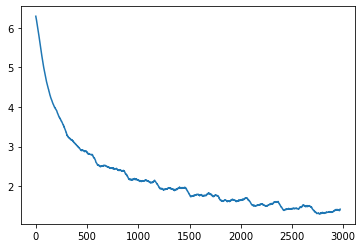

In [5]:
def smooth(x, size):
  return np.convolve(x, np.ones(size)/size, mode='valid')
state = torch.load(checkpoints + "resnet18v2checkpoint-10.pkl")
losses = state['losses']
plt.plot(smooth(losses,50))

### Continue to train Resnet 18

In [ ]:
torch.device('cuda')
resnet = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=True)
resnet.fc = nn.Linear(512, 555) # This will reinitialize the layer as well

state = torch.load(checkpoints + ' resnet18v2checkpoint-3.pkl')
resnet.to(device)

losses = train(resnet, data['train'], epochs=75, lr=.001, print_every=10, decay=.0009, checkpoint_path=checkpoints + "resnet18v2", state=state)

### Get losses from a checkpoint


In [ ]:
def smooth(x, size):
  return np.convolve(x, np.ones(size)/size, mode='valid')

plt.plot(smooth(losses,50))

In [ ]:
def accuracy(net, dataloader):
  correct = 0
  total = 0
  with torch.no_grad():
      for batch in dataloader:
          images, labels = batch[0].to(device), batch[1].to(device)
          outputs = net(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
  return correct/total


### Print Accuracy of Resnet18

In [ ]:

device = torch.device("cuda")

resnet = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18',pretrained=True)
resnet.fc = nn.Linear(512, 555) # This will reinitialize the layer as well

state = torch.load(checkpoints + '_resnet18checkpoint-15.pkl', map_location='cuda')
# state_dict = state['net']
# new_state_dict = {}
# for k, v in state_dict.items():
#     name = k.replace('module.', '')  # remove 'module.' from key names (if present)
#     new_state_dict[name] = v
# resnet.load_state_dict(new_state_dict, map_location=device)

resnet.load_state_dict(state['net'])


print("Current accuracy: %f" % accuracy(resnet, data['train']))

In [ ]:
def predict(net, dataloader, ofname):
    out = open(ofname, 'w')
    out.write("path,class\n")
    net.to(device)
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for i, (images, labels) in enumerate(dataloader, 0):
            if i%100 == 0:
                print(i)
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            fname, _ = dataloader.dataset.samples[i]
            out.write("test/{},{}\n".format(fname.split('/')[-1], data['to_class'][predicted.item()]))
    out.close()

In [ ]:
# Load model from checkpoint
resnet = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=True)
resnet.fc = nn.Linear(512, 555) # This will reinitialize the layer as well
state = torch.load(checkpoints + '_resnet18checkpoint-12.pkl')
resnet.load_state_dict(state['net'])


predict(resnet, data['test'], checkpoints + "ResNet18_E12.csv")

# EfficientNet

In [ ]:
import torch.nn as nn
import torchvision.models as models
# !pip install efficientnet_pytorch
# from efficientnet_pytorch import EfficientNet


device = torch.device("cuda")
efficientNet =  models.efficientnet_v2_s(pretrained=True)
# num_ftrs = efficientNet.classifier.in_features
# efficientNet.classifier = torch.nn.Linear(efficientNet.classifier.in_features, 555)

num_ftrs = efficientNet.classifier[-1].in_features
efficientNet.classifier[-1] = nn.Linear(num_ftrs, 555)

# efficientNet.classifier[1] = nn.Linear(in_features=1280, out_features=555)

# state = torch.load(checkpoints + "bestSoFar.pkl")
# ftrs = efficientNet.
# efficientNet.classifier = nn.Linear(efficientNet.classifier.in_features, 555) # This will reinitialize the layer as well
efficientNet.to(device)
losses = train(efficientNet, data['train'], epochs=9, schedule={0:.01, 3:.001, 6:.0001, 8:.00001}, print_every=25, checkpoint_path= checkpoints + "efficientNetVersion2_S")

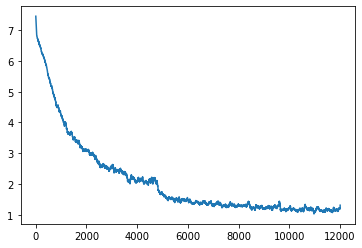

In [ ]:
def smooth(x, size):
  return np.convolve(x, np.ones(size)/size, mode='valid')

# checkpoint = torch.load(checkpoints + "_efficientNetcheckpoint-10.pkl")
# losses = checkpoint['losses']
plt.plot(smooth(losses,50))

In [ ]:
print("Current accuracy of efficientNet: %f" % accuracy(efficientNet, data['train']))

Current accuracy of efficientNet: 0.507702


In [ ]:
# Load model from checkpoint
import torch.nn as nn
import torchvision.models as models
device = torch.device("cpu")

efficientNet =  models.efficientnet_v2_s(pretrained=True)
# num_ftrs = efficientNet.classifier.in_features
# efficientNet.classifier = torch.nn.Linear(efficientNet.classifier.in_features, 555)

num_ftrs = efficientNet.classifier[-1].in_features
efficientNet.classifier[-1] = nn.Linear(num_ftrs, 555)


state = torch.load(checkpoints + 'efficientNetVersion2_Scheckpoint-6.pkl', map_location=torch.device(device))
efficientNet.load_state_dict(state['net'])

predict(efficientNet, data['test'], checkpoints + "EfficientNetv2sPred.csv")

# resnet152
*italicized text*

In [ ]:
import torchvision.models as models

device = torch.device("cuda")
resnet152 = torch.hub.load('pytorch/vision:v0.9.0', 'resnet152', pretrained=True)
resnet152.fc = nn.Linear(512, 555) # This will reinitialize the layer as well

losses = train(resnet152, data['train'], epochs=15, lr=.01, print_every=10, checkpoint_path=checkpoints + "resnet152")

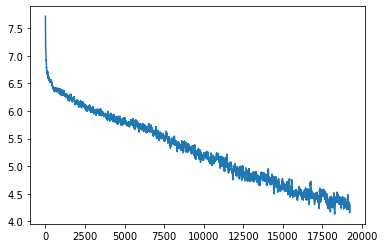

In [ ]:
def smooth(x, size):
  return np.convolve(x, np.ones(size)/size, mode='valid')
plt.plot(smooth(losses,50))

In [ ]:
print("Current accuracy of efficientNet: %f" % accuracy(resnet152, data['train']))

Current accuracy of efficientNet: 0.069602


In [ ]:
# Load model from checkpoint
resnet152 = torch.hub.load('pytorch/vision:v0.9.0', 'resnet152', pretrained=True)

state = torch.load(checkpoints + 'checkpoint-5.pkl')
resnet152.load_state_dict(state['net'])


predict(resnet152, data['test'], checkpoints + "ResNet152Pred.csv")

# Resnet 50

In [11]:
device = torch.device("cuda")
resnet50 = torch.hub.load('pytorch/vision:v0.9.0', 'resnet50', pretrained=True)
resnet50.fc = nn.Linear(resnet50.fc.in_features, 555) # This will reinitialize the layer as well
resnet50.to(device)
#uncomment if we have previously trained the model and have checkpoints in the drive
# state = torch.load(checkpoints + "_resnet50" + 'checkpoint-3.pkl')
# resnet50.load_state_dict(state['net'])

losses = train(resnet50, data['train'], epochs=13, start_epoch = 12, lr=.000001, print_every=50, decay=.0009, checkpoint_path=checkpoints + "_resnet50")

Downloading: "https://github.com/pytorch/vision/zipball/v0.9.0" to /root/.cache/torch/hub/v0.9.0.zip


KeyboardInterrupt: ignored

### Create Loss Graph

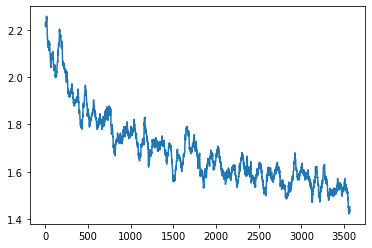

In [12]:
def smooth(x, size):
  return np.convolve(x, np.ones(size)/size, mode='valid')

checkpoint = torch.load(checkpoints + "_resnet50" + 'checkpoint-3.pkl')
losses = checkpoint['losses']
plt.plot(smooth(losses,50))

### Calculate the Accuracy

In [ ]:
print("Current accuracy of ResNet50: %f" % accuracy(resnet50, data['train']))

Current accuracy of ResNet50: 0.715264


### Create Predicion CSV

In [ ]:
# Load model from checkpoint
# resnet50 = models.__dict__['efficientnet_b0'](pretrained=True)
resnet50 = torch.hub.load('pytorch/vision:v0.9.0', 'resnet50', pretrained=True)
resnet50.fc = nn.Linear(resnet50.fc.in_features, 555) # This will reinitialize the layer as well
state = torch.load(checkpoints + "_resnet50" + 'checkpoint-13.pkl')
resnet50.load_state_dict(state['net'])


predict(resnet50, data['test'], checkpoints + "ResNet50Pred4.csv")